In [1]:
import math
import json
import pandas as pd
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

In [296]:
def calc_cost(distance):
    """
    determine the cost of the movement according to the rules:
    Each swing costs the particle $D^-2, where D is the straight-line distance of the length of rope used for that particular swing.
    """
    return round(pow(distance, -2),4)

def calc_distance(x1,y1,x2,y2): 
    """
    determine the distance between 2 points on a coordinate plane
    """
    return round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2),4)

def calc_slope(x1,y1,x2,y2):
    ##(0,0) => (5,0)
    if x1 == x2 and y1 == y2:
        return "NaL"
    elif x1 == x2:
        if y1 < y2:
            return "vertical_pos"
        elif y1 > y2:
            return "vertical_neg"
    elif y1 == y2:
        if x1 < x2:
            return "horizontal_pos"
        elif x1 > x2:
            return "horizontal_neg"
    else:
#         if slope > 0:
#             return str(slope)+"_pos"
#         elif slope < 0:
#             return str(slope)+"_neg"
        return round((y2-y1)/(x2-x1),4)
    
def plot_path(x1,y1,x2,y2, color="b"):
    # plot points
    ax.plot(x1, y1, color+'o')
    ax.plot(x2, y2, color+'o')
    # plot line
    ax.plot([x1, x2],[y1, y2], color+'-')

def lattice_intercepts(origin, radius):
    x = origin[0]
    y = origin[1]
    r_2 = round(pow(radius,2),2) # rounding to nearest 10th...
    xy_2 = (pow(x,2) + pow(y,2))
    lattice_intercepts = []
    i = 0
    while i <= xy_2:
        j = 0
        while j <= xy_2:
            if (pow((i - x),2) + pow((j - y),2) == r_2):
                lattice_intercepts.append((i,j))
            j = j + 1
        i = i + 1
    return lattice_intercepts

def calc_angle(p0, p1, p2):
    """
    calculate the angle (in degrees) for vertex p0 p1 p2 
    """
    v0 = np.array(p0) - np.array(p1)
    v1 = np.array(p2) - np.array(p1)
    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return round(np.degrees(angle),4)

def inbounds(origin, thru_pt, distance, slope):

    x = origin[0]
    y = origin[1]
    x_tp = thru_pt[0]
    y_tp = thru_pt[1]
    
    inbounds = True

    if slope == "vertical_pos":
        x1 = x
        y1 = y + distance
        if y1 > 20.5:
            inbounds = False
    elif slope == "vertical_neg":
        x1 = x
        y1 = y - distance
        if y1 < 0.5:
            inbounds = False
    elif slope == "horizontal_pos":
        x1 = x + distance
        y1 = y
        if x1 > 20.5:
            inbounds = False
    elif slope == "horizontal_neg":
        x1 = x - distance
        y1 = y
        if x1 < 0.5:
            inbounds = False
    else:
        c = 1/math.sqrt(1+pow(slope,2))
        s = slope/math.sqrt(1+pow(slope,2))

        # QUADRANT 1
        if x < x_tp and y < y_tp:
            x1 = (x+distance*c)
            y1 = (y+distance*s)
        # QUADRANT 2
        elif x < x_tp and y > y_tp:
            x1 = (x+distance*c)
            y1 = (y+distance*s)
        # QUADRANT 3
        elif x > x_tp and y > y_tp:
            x1 = (x-distance*c)
            y1 = (y-distance*s)
        # QUADRANT 4
        elif x > x_tp and y < y_tp:
            x1 = (x-distance*c)
            y1 = (y-distance*s)

        if x1 < 0.5 or x1 > 20.5 or y1 < 0.5 or y1 > 20.5:
            inbounds = False
#     print(str((x,y,x1,y1)))
    plot_path(x,y,x1,y1,"y")
    plot_path(x,y,x_tp,y_tp,"c")
    return inbounds

def excel_col(col):
    quot, rem = divmod(col-1,26)
    return excel_col(quot) + chr(rem+ord("A")) if col!=0 else ""

{'-1.1176_q4': (3.0, 20.0, 25.4951, -1.1176), '-1.2667_q4': (5.0, 20.0, 24.2074, -1.2667), '-2.1111_q4': (11.0, 20.0, 21.0238, -2.1111), '-3.8_q4': (15.0, 20.0, 19.6469, -3.8), '-6.3333_q4': (17.0, 20.0, 19.2354, -6.3333), '-9.0_q4': (18.0, 19.0, 18.1108, -9.0), '-18.0_q4': (19.0, 19.0, 18.0278, -18.0), '-1.4167_q4': (8.0, 18.0, 20.8087, -1.4167), '-2.8333_q4': (14.0, 18.0, 18.0278, -2.8333), '-4.25_q4': (16.0, 18.0, 17.4642, -4.25), '-17.0_q4': (19.0, 18.0, 17.0294, -17.0), '-0.8421_q4': (1.0, 17.0, 24.8395, -0.8421), '-1.4545_q4': (9.0, 17.0, 19.4165, -1.4545), '-3.2_q4': (15.0, 17.0, 16.7631, -3.2), '-0.9375_q4': (4.0, 16.0, 21.9317, -0.9375), '-1.0_q4': (1.0, 20.0, 26.8701, -1.0), '-1.875_q4': (12.0, 16.0, 17.0, -1.875), '-7.5_q4': (18.0, 16.0, 15.1327, -7.5), '-3.5_q4': (16.0, 15.0, 14.5602, -3.5), '-1.8571_q4': (13.0, 14.0, 14.7648, -1.8571), '-3.0_q4': (18.0, 7.0, 6.3246, -3.0), '-12.0_q4': (19.0, 13.0, 12.0416, -12.0), '-0.5263_q4': (1.0, 11.0, 21.4709, -0.5263), '-0.625_q4': (

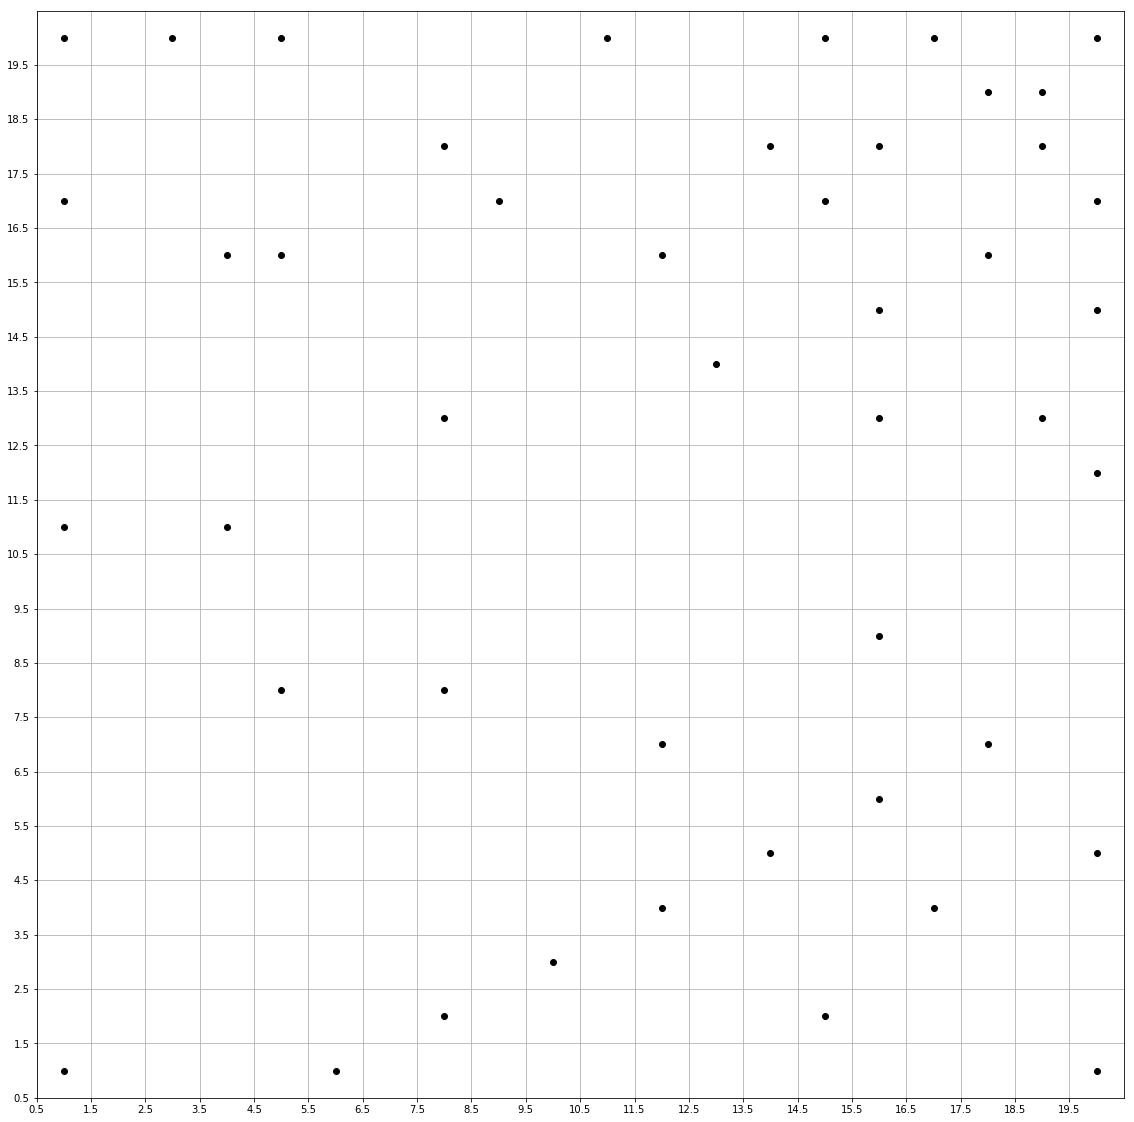

In [350]:
coords = [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, 20.0), (15.0, 20.0), (17.0, 20.0), (20.0, 20.0), (18.0, 19.0), (19.0, 19.0), (8.0, 18.0), (14.0, 18.0), (16.0, 18.0), (19.0, 18.0), (1.0, 17.0), (9.0, 17.0), (15.0, 17.0), (20.0, 17.0), (4.0, 16.0), (5.0, 16.0), (12.0, 16.0), (18.0, 16.0), (16.0, 15.0), (20.0, 15.0), (13.0, 14.0), (8.0, 13.0), (16.0, 13.0), (19.0, 13.0), (20.0, 12.0), (1.0, 11.0), (4.0, 11.0), (16.0, 9.0), (5.0, 8.0), (8.0, 8.0), (12.0, 7.0), (18.0, 7.0), (16.0, 6.0), (14.0, 5.0), (20.0, 5.0), (12.0, 4.0), (17.0, 4.0), (10.0, 3.0), (8.0, 2.0), (15.0, 2.0), (1.0, 20.0), (6.0, 1.0), (20.0, 1.0)]
graph = {} 

figure(figsize=(20,20))
ax=subplot(aspect='equal')
ax.set_xticks(np.arange(.5, 20.5, 1))
ax.set_yticks(np.arange(.5, 20.5, 1))
# ax.set_xticks(np.arange(0, 20, 1))
# ax.set_yticks(np.arange(0, 20, 1))

# plot all coordinates
[ax.plot(i[0], i[1], 'ko') for i in coords]

# ax.plot(4.6098,0.3902, 'go')

# plot start and finish
# ax.fill_between([-.5,.5], -.5, .5, facecolor='yellow')
# ax.fill_between([18.5,19.5], 18.5, 19.5, facecolor='yellow')

# ax.fill_between([15,16], 19, 20, facecolor='red')
# ax.fill_between([16,17], 18, 19, facecolor='red')
# ax.fill_between([17,18], 17, 18, facecolor='red')
# ax.fill_between([18,19], 16, 17, facecolor='red')
# ax.fill_between([19,20], 15, 16, facecolor='red')

xlim(.5,20.5)
ylim(.5,20.5)
# xlim(0,20)
# ylim(0,20)

# build the graph
for i in range(len(coords)):
    x1 = coords[i][0]
    y1 = coords[i][1]
    # first toss START
    # x1 = 0
    # y1 = 0
    viable_toss_stack = {}
    toss = []
    toss_length = 0
    for j in coords:
        x2 = j[0]
        y2 = j[1]
        distance = calc_distance(x1,y1,x2,y2)
        slope = calc_slope(x1,y1,x2,y2)
       if slope not in viable_toss_stack:
            viable_toss_stack[slope] = (x2,y2,distance,slope)
        else:
            if abs(viable_toss_stack[slope][2]) > abs(distance):
                del viable_toss_stack[slope]
                viable_toss_stack[slope] = (x2,y2,distance,slope)
            elif abs(viable_toss_stack[slope][2]) == abs(distance):
                viable_toss_stack[slope] = (x2,y2,distance,slope)             

                
    for k in viable_toss_stack:
        toss.append((viable_toss_stack[k][0], viable_toss_stack[k][1], viable_toss_stack[k][2], viable_toss_stack[k][3]))
        # toss.append((viable_toss_stack[k][0], viable_toss_stack[k][1]))
        graph[(x1,y1)] = toss
        
# print(viable_toss_stack)
# store viable landing points
# lp_graph = {}

print(graph)

# graph search loop
# FIND EVERY FIRST MOVE Landing Point!
for i in graph:
    x1 = i[0]
    y1 = i[1]
    for j in graph[i]:
        x2 = j[0]
        y2 = j[1]
        d2 = j[2]
        s2 = j[3]
        
        g_pos = 180
        d_pos_rem = 0
        g_pos_stack = (0,0,0,0,0)

        g_neg = -180
        d_neg_rem = 0
        g_neg_stack = (0,0,0,0,0)


        
        
#         if x1 == 1 and y1 == 1 and x2 == 3.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 11.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 17.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 19.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 14.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 19.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 9.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 4.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 15.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 15.0:
#         if x1 == 1 and y1 == 1 and x2 == 13.0 and y2 == 14.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 13.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 13.0:
#         if x1 == 1 and y1 == 1 and x2 == 19.0 and y2 == 13.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 12.0:
#         if x1 == 1 and y1 == 1 and x2 == 1.0 and y2 == 11.0:
#         if x1 == 1 and y1 == 1 and x2 == 4.0 and y2 == 11.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 9.0:
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 8.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 8.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 7.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 7.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 6.0:
        if x1 == 1 and y1 == 1 and x2 == 14.0 and y2 == 5.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 5.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 4.0:
#         if x1 == 1 and y1 == 1 and x2 == 17.0 and y2 == 4.0:
#         if x1 == 1 and y1 == 1 and x2 == 10.0 and y2 == 3.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 2.0:
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 2.0:
#         if x1 == 1 and y1 == 1 and x2 == 6.0 and y2 == 1.0:        
#         if x1 == 1 and y1 == 1:
            if (x1,y1) != (x2,y2) and s2 != "NaL":
                print("toss: ("+str(x1)+","+str(y1)+") => ("+str(x2)+","+str(y2)+") | d:"+str(d2)+" | s:"+str(s2))
                for k in graph[(x2,y2)]:
                    x3 = k[0]
                    y3 = k[1]
                    d3 = k[2]
                    s3 = k[3]
                    g = calc_angle((x1,y1),(x2,y2),(x3,y3))
                    
                    if d3 < d2 and s3 != "NaL":

                        if 0 < g < g_pos:
                            g_pos = g
                            d_pos_rem = d2 - d3
                            g_pos_stack = (x3,y3,d_pos_rem,s3,g)
                        elif 0 > g > g_neg:
                            g_neg = g
                            d_neg_rem = d2 - d3
                            g_neg_stack = (x3,y3,d_neg_rem,s3,g)
#                         print("    swing: ("+str(x2)+","+str(y2)+") => ("+str(x3)+","+str(y3)+") | d:"+str(d3)+" | g:"+str(g)+"\u00B0"+" | s:"+str(s3))
                
                lps = lattice_intercepts((x2,y2), d2)
            
                print("    g_pos_swing: ("+str(x2)+","+str(y2)+") => ("+str(g_pos_stack[0])+","+str(g_pos_stack[1])+") | d:"+str(g_pos_stack[2])+" | s:"+str(g_pos_stack[3])+" | g:"+str(g_pos_stack[4])+"\u00B0")
#                 ax.plot(g_pos_stack[0],g_pos_stack[1], 'go')
                print("    g_neg_swing: ("+str(x2)+","+str(y2)+") => ("+str(g_neg_stack[0])+","+str(g_neg_stack[1])+") | d:"+str(g_neg_stack[2])+" | s:"+str(g_neg_stack[3])+" | g:"+str(g_neg_stack[4])+"\u00B0")
#                 ax.plot(g_neg_stack[0],g_neg_stack[1], 'go')
#                 print("    x2: "+str(x2))
#                 print("    y2: "+str(y2))
#                 print("    d2: "+str(d2))
                print("    lps: "+str(lps))
                print("___________")

                plot_path(x1,y1,x2,y2,"b")
                
                
                # positive swing possibilities 
#                 print(">>> p (x2,y2): "+str((x2,y2)))
#                 print(">>> p distance: "+str(d2))
#                 print(">>> p slope: "+str(g_pos_stack[3]))
                if g_pos_stack != (0,0,0,0,0) and inbounds((x2,y2), (g_pos_stack[0],g_pos_stack[1]), d2, calc_slope(x2,y2,g_pos_stack[0],g_pos_stack[1])):
                    plot_path(x2,y2,g_pos_stack[0],g_pos_stack[1],"m")
                    g_p = g_pos_stack[4]
                    for l in lps:
                        x4_p = l[0]
                        y4_p = l[1]
                        g2_p = calc_angle((x1,y1),(x2,y2),(x4_p,y4_p))
#                         print("        pt1_p: "+str([(x1,y1),(x2,y2),(x4_p,y4_p)])+" |"+str(g2_p) + " < " + str(g_p))
                        if 0 <= g2_p <= g_p and (x4_p,y4_p) != (x1,y1):
                            ax.plot(x4_p,y4_p, 'go')

                    # recursive search until rope runs out...
                    print("        positive swing possibilities:")
                    for i_p in graph[(g_pos_stack[0],g_pos_stack[1])]:
                        if g_pos_stack[2] > i_p[2] and (g_pos_stack[0],g_pos_stack[1]) != (i_p[0],i_p[1]):
                            pass
#                             print("        swing: ("+str(g_pos_stack[0])+","+str(g_pos_stack[1])+") => ("+str(i_p[0])+","+str(i_p[1])+") | d:"+str(i_p[2])+" s:"+str(i_p[3]))
#                             plot_path(g_pos_stack[0],g_pos_stack[1],i_p[0],i_p[1],"y")
                              
                
                # negative swing possibilities
#                 print(">>> n (x2,y2): "+str((x2,y2)))
#                 print(">>> n distance: "+str(d2))
#                 print(">>> n slope: "+str(g_neg_stack[3]))
                if g_neg_stack != (0,0,0,0,0) and inbounds((x2,y2), (g_neg_stack[0],g_neg_stack[1]), d2, calc_slope(x2,y2,g_neg_stack[0],g_neg_stack[1])):
                    plot_path(x2,y2,g_neg_stack[0],g_neg_stack[1],"m")
                    g_n = g_neg_stack[4]
                    for l in lps:
                        x4_n = l[0]
                        y4_n = l[1]
                        g2_n = calc_angle((x1,y1),(x2,y2),(x4_n,y4_n))
#                         print("        pt1_n: "+str([(x1,y1),(x2,y2),(x4_n,y4_n)])+" |"+str(g2_n) + " > " + str(g_n))
                        if 0 >= g2_n >= g_n and (x4_n,y4_n) != (x1,y1):
                            ax.plot(x4_n,y4_n, 'go')
            
                    # recursive search until rope runs out...
                    print("        negative swing possibilities:")
                    for i_n in graph[(g_neg_stack[0],g_neg_stack[1])]:
                        if g_neg_stack[2] > i_n[2] and (g_neg_stack[0],g_neg_stack[1]) != (i_n[0],i_n[1]):
                            pass
#                             print("        swing: ("+str(g_neg_stack[0])+","+str(g_neg_stack[1])+") => ("+str(i_n[0])+","+str(i_n[1])+") | d:"+str(i_n[2])+" | s:"+str(i_n[3]))
#                             plot_path(g_neg_stack[0],g_neg_stack[1],i_n[0],i_n[1],"y")
            
            
                
                
                    
                
                
            
            
# print(lp_graph)            
plt.grid() 

In [349]:
print(graph[(1.0, 1.0)])

[(1.0, 1.0, 0.0, 'NaL'), (1.0, 11.0, 10.0, 'vertical_pos'), (6.0, 1.0, 5.0, 'horizontal_pos')]
